In [1]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import torch
import os
import re

In [2]:
torch.manual_seed(256)
torch.cuda.manual_seed(256)
np.random.seed(256)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

Using cpu device.


## 2.1 Word embedding

1. Read txt files and tokenize them to obtain train/validation/test lists of words.

In [4]:
TOKENIZER = get_tokenizer("basic_english")


def read_txt_files(datapath):
    files = os.listdir(datapath)
    files = [datapath + f for f in files if f.endswith(".txt")]

    lines = []
    for f_name in files:
        with open(f_name) as f:
            lines += f.readlines()
    return lines


def tokenize(lines, tokenizer=TOKENIZER):
    list_text = []
    for line in lines:
        list_text += tokenizer(line)
    return list_text


def yield_tokens(lines, tokenizer=TOKENIZER):
    no_digits = "\w*[0-9]+\w*"  # Regex to match words containing numbers
    no_names = "\w*[A-Z]+\w*"  # Regex to match words with capital letters (names)
    no_spaces = "\s+"  # Regex to match sequences of whitespace

    # Processing each line to remove digits, names, and extra spaces
    for line in lines:
        line = re.sub(no_digits, " ", line)
        line = re.sub(no_names, " ", line)
        line = re.sub(no_spaces, " ", line)
        # Yielding the tokenized and cleaned line
        yield tokenizer(line)

In [5]:
GENERATED_PATH = "./generated/"  # Path where generated data files are stored

# Check if the training data file already exists in the generated path
if os.path.isfile(GENERATED_PATH + "words_train.pt"):
    # Load preprocessed training, validation, and test word lists from .pt files
    words_train = torch.load(GENERATED_PATH + "words_train.pt")
    words_val = torch.load(GENERATED_PATH + "words_val.pt")
    words_test = torch.load(GENERATED_PATH + "words_test.pt")
else:
    # If preprocessed data does not exist, read text files
    lines_books_train = read_txt_files("data/data_train/")
    lines_books_val = read_txt_files("data/data_val/")
    lines_books_test = read_txt_files("data/data_test/")

    # Tokenize the lines from train, validation, and test datasets
    words_train = tokenize(lines_books_train)
    words_val = tokenize(lines_books_val)
    words_test = tokenize(lines_books_test)

    # Save the tokenized word lists to .pt files
    torch.save(words_train, GENERATED_PATH + "words_train.pt")
    torch.save(words_val, GENERATED_PATH + "words_val.pt")
    torch.save(words_test, GENERATED_PATH + "words_test.pt")

2. Define a vocabulary based on the training dataset. To avoid getting a too large vocabulary, a solution can be to keep only words that appear at least 100 times in the training dataset. Report the total number of words in the training dataset, the number of distinct words in the training dataset, and the size of the defined vocabulary. Comment on your results.

In [6]:
MIN_FREQ = 100


def create_vocabulary(lines, min_freq=MIN_FREQ):
    # Building vocabulary from an iterator of tokenized lines, filtering out infrequent tokens
    vocab = build_vocab_from_iterator(yield_tokens(lines), min_freq=min_freq,
                                      specials=["<unk>", ',', '.', '(', ')', '?', '!'])
    # Appending token "I", since we removed all words with an uppercase when building the vocabulary
    vocab.append_token("i")
    # Setting default index for unknown words
    vocab.set_default_index(vocab["<unk>"])
    return vocab

In [7]:
VOCAB_FILENAME = "vocabulary.pt"

# Check if the vocabulary file already exists in the generated path
if os.path.isfile(GENERATED_PATH + VOCAB_FILENAME):
    # Load the vocabulary from a file if it already exists
    vocab = torch.load(GENERATED_PATH + VOCAB_FILENAME)
else:
    # If the vocabulary file does not exist, create a new vocabulary from training data
    vocab = create_vocabulary(lines_books_train, min_freq=MIN_FREQ)
    # Save the newly created vocabulary to a file
    torch.save(vocab, GENERATED_PATH + VOCAB_FILENAME)

VOCAB_SIZE = len(vocab)

In [8]:
print(f"Total number of words in the training dataset: {len(words_train):,}")
print(f"Total number of words in the validation dataset: {len(words_val):,}")
print(f"Total number of words in the test dataset: {len(words_test):,}", end="\n\n")

print(f"Number of distinct words in the training dataset: {len(set(words_train)):,}")
print(f"Number of distinct words in the validation dataset: {len(set(words_val)):,}")
print(f"Number of distinct words in the test dataset: {len(set(words_test)):,}", end="\n\n")

print(f"Size of the defined vocabulary: {VOCAB_SIZE:,}")

Total number of words in the training dataset: 2,684,706
Total number of words in the validation dataset: 49,526
Total number of words in the test dataset: 124,152

Number of distinct words in the training dataset: 52,105
Number of distinct words in the validation dataset: 5,778
Number of distinct words in the test dataset: 9,585

Size of the defined vocabulary: 1,880


In [9]:
def count_occurrences(words, vocab):
    occurrences = torch.zeros(len(vocab), dtype=torch.int)
    for w in words:
        occurrences[vocab[w]] += 1
    return occurrences

In [10]:
word_counts_df = pd.DataFrame({
    "Word": vocab.lookup_tokens(range(len(vocab))),
    "Occurrences": count_occurrences(words_train, vocab).numpy()
})

sorted_word_counts = word_counts_df.sort_values(by="Occurrences", ascending=False).reset_index(drop=True)
sorted_word_counts.index = sorted_word_counts.index + 1

In [11]:
sorted_word_counts

,Word,Occurrences
1,<unk>,433907
2,",",182537
3,the,151278
4,.,123727
5,and,82289
...,...,...
1876,pistol,100
1877,slipped,100
1878,station-master,100
1879,wounds,100


In [12]:
CONTEXT_SIZE = 3  # Number of words considered before and after the target word


def create_context_target_dataset(text, vocab, context_size=CONTEXT_SIZE):
    contexts = []
    targets = []

    for i in range(context_size, len(text) - context_size):
        target = text[i]
        target_idx = vocab[target]

        context = [vocab[text[j]] for j in range(i - context_size, i + context_size + 1) if j != i]

        targets.append(target_idx)
        contexts.append(torch.tensor(context))

    return TensorDataset(torch.stack(contexts), torch.tensor(targets))

# def create_context_target_dataset(text, vocab, context_size=CONTEXT_SIZE, max_occurrences=None):
#     target_counts = {}
#     contexts = []
#     targets = []
# 
#     # Loop over the words list with enough space to form the context window
#     for i in range(context_size, len(text) - context_size):
#         target_word = text[i]
# 
#         # Skip if the target word is punctuation
#         if target_word in [',', '.', '(', ')', '?', '!']:
#             continue
# 
#         # Convert the word to its vocabulary index, skip if not in vocabulary
#         target_idx = vocab.get_stoi().get(target_word, None)
#         if target_idx is None:
#             continue
# 
#         # Limit occurrences of each word
#         if max_occurrences is not None:
#             if target_word in target_counts and target_counts[target_word] >= max_occurrences:
#                 continue
#             target_counts[target_word] = target_counts.get(target_word, 0) + 1
# 
#         # Extract the context words: context_size words before and context_size words after the target word
#         context = [vocab[text[j]] for j in range(i - context_size, i + context_size + 1) if j != i]
#         contexts.append(torch.tensor(context))
#         targets.append(target_idx)
# 
#     return TensorDataset(torch.stack(contexts), torch.tensor(targets, dtype=torch.long))

In [13]:
def load_dataset(words, vocab, filename, generated_path=GENERATED_PATH):
    full_path = os.path.join(generated_path, filename)
    if os.path.isfile(full_path):
        return torch.load(full_path)
    else:
        dataset = create_context_target_dataset(words, vocab)
        torch.save(dataset, full_path)
        return dataset


data_train = load_dataset(words_train, vocab, "data_train.pt")
data_val = load_dataset(words_val, vocab, "data_val.pt")
data_test = load_dataset(words_test, vocab, "data_test.pt")

In [14]:
print(f"Training dataset size: {len(data_train):,}")
print(f"Validation dataset size: {len(data_val):,}")
print(f"Test dataset size: {len(data_test):,}")

Training dataset size: 2,684,700
Validation dataset size: 49,520
Test dataset size: 124,146


In [15]:
BATCH_SIZE = 128

train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)

3. Define a continuous bag of words model architecture based on this vocabulary that contains an embedding layer. To drastically reduce the computational cost, the dimension of the embedding `emb_dim` can be very low such as 16, 12, or even 10. Of course, in a real setting, a larger space would be used. You are not allowed to use `nn.LazyLinear` in this project.

https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

In [16]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim):
        super(CBOW, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(emb_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        out = self.embedding(x).sum(dim=1)
        out = self.lin1(out)
        out = self.relu(out)
        out = self.lin2(out)
        out = F.log_softmax(out, dim=1)
        return out

In [17]:
def train_model(model, train_loader, optimizer, loss_fn, epochs=20):
    training_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for contexts, targets in train_loader:
            contexts, targets = contexts.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(contexts)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        timestamp = datetime.now().strftime('%H:%M:%S.%f')
        print(f"\r{timestamp} | Epoch {epoch} | Training Loss: {avg_train_loss:.5f}", end="")

    return training_losses

In [18]:
def calculate_weights(data, num_classes):
    # Initialize counts with zeros for each possible word index
    counts = torch.zeros(num_classes, dtype=torch.int)

    # Count occurrences of each word in the dataset
    for word in data:
        word_idx = vocab[word]
        counts[word_idx] += 1

    # Total number of samples
    total_samples = counts.sum()

    # Weights for each class
    weights = total_samples / (counts * VOCAB_SIZE)

    # Replace inf/NaN with zero (in case some classes do not appear in the counts)
    weights[torch.isinf(weights) | torch.isnan(weights)] = 0

    # Normalize weights so that their maximum is 1
    weights = weights / weights.max()

    return weights.to(device)

In [19]:
class_weights = calculate_weights(words_train, num_classes=VOCAB_SIZE)

In [69]:
def ensure_directory_exists(folder):
    """Creates the directory if it does not exist."""
    os.makedirs(folder, exist_ok=True)

In [20]:
def save_losses(train_losses, model_name, folder="losses"):
    ensure_directory_exists(folder)
    filepath = os.path.join(folder, f"{model_name}_losses.csv")
    df = pd.DataFrame({
        "train_loss": train_losses
    })
    df.to_csv(filepath, index=False)

In [21]:
def load_losses(model_name, folder="losses"):
    filepath = os.path.join(folder, f"{model_name}_losses.csv")
    df = pd.read_csv(filepath)
    return df['train_loss'].tolist()

In [22]:
def save_model(model, model_name, folder="models"):
    filepath = os.path.join(folder, f"{model_name}.pth")
    torch.save(model.state_dict(), filepath)

In [23]:
def load_model(model, model_name, folder="models"):
    ensure_directory_exists(folder)
    filepath = os.path.join(folder, f"{model_name}.pth")
    model.load_state_dict(torch.load(filepath, map_location=device))
    model.to(device)
    return model

In [50]:
configurations = [
    # {'emb_dim': 10, 'hidden_dim': 64, 'learning_rate': 1e-3, 'model_name': 'cbow_model_emb10_hidden64_lr1e-3'},
    # {'emb_dim': 16, 'hidden_dim': 64, 'learning_rate': 1e-4, 'model_name': 'cbow_model_emb16_hidden64_lr1e-4'},
    # {'emb_dim': 10, 'hidden_dim': 128, 'learning_rate': 1e-4, 'model_name': 'cbow_model_emb10_hidden128_lr1e-4'},
    # {'emb_dim': 20, 'hidden_dim': 128, 'learning_rate': 1e-5, 'model_name': 'cbow_model_emb20_hidden128_lr1e-5'},
    # {'emb_dim': 64, 'hidden_dim': 128, 'learning_rate': 1e-5, 'model_name': 'cbow_model_emb64_hidden128_lr1e-5'},
    # {'emb_dim': 84, 'hidden_dim': 128, 'learning_rate': 1e-5, 'model_name': 'cbow_model_emb84_hidden128_lr1e-5'},
    # {'emb_dim': 64, 'hidden_dim': 256, 'learning_rate': 1e-4, 'model_name': 'cbow_model_emb64_hidden256_lr1e-4'},
    # {'emb_dim': 128, 'hidden_dim': 128, 'learning_rate': 1e-4, 'model_name': 'cbow_model_emb128_hidden128_lr1e-4'}
    {'emb_dim': 64, 'hidden_dim': 128, 'learning_rate': 1e-3, 'model_name': 'cbow_model_emb64_hidden128_lr1e-3'}
]

In [51]:
for config in configurations:
    model = CBOW(vocab_size=VOCAB_SIZE, emb_dim=config['emb_dim'], hidden_dim=config['hidden_dim']).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    loss_fn = nn.NLLLoss()

    print(f"Training {config['model_name']}...")
    model_losses = train_model(model, train_loader, optimizer, loss_fn, epochs=20)

    save_model(model, config['model_name'])
    save_losses(model_losses, config['model_name'])

Training cbow_model_emb64_hidden128_lr1e-3...
17:11:59.051784 | Epoch 20 | Training Loss: 4.02004

In [52]:
def plot_losses(model_names):
    cmap = plt.get_cmap("Paired")

    for i, model_name in enumerate(model_names):
        losses = load_losses(model_name)
        plt.plot(losses, label=model_name, color=cmap(i))

    plt.title("Model Losses During Training")
    plt.xlabel("Epochs")
    plt.ylabel("Training Loss")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Model Names")
    plt.grid(color='silver', linestyle='--', linewidth=0.5)
    plt.show()

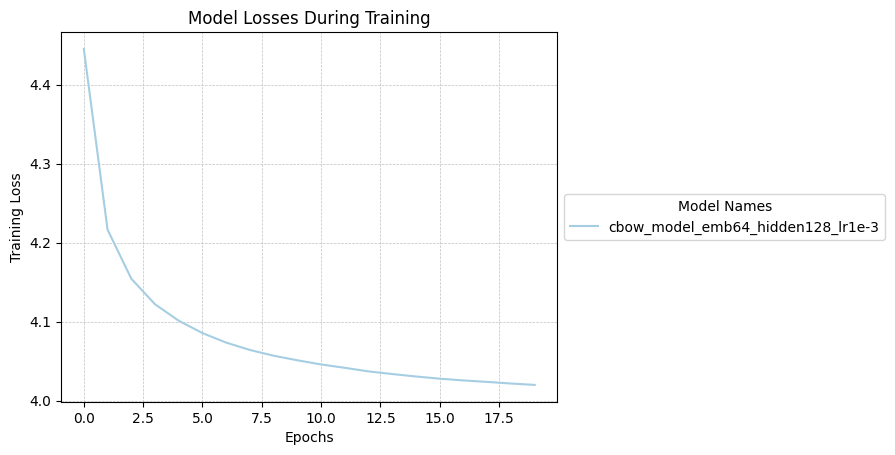

In [53]:
plot_losses([config['model_name'] for config in configurations])

4. Train several models, select the best one, and evaluate its performance. Note that the performance here is potentially extremely low, but the real objective is not to train a good predictor, only to have a good representation of the semantics of each word in the vocabulary.

In [200]:
def accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for contexts, targets in data_loader:
            contexts, targets = contexts.to(device), targets.to(device)
            outputs = model(contexts)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total

In [55]:
def load_and_evaluate_models(configurations, val_loader):
    best_model = None
    best_model_name = ""
    best_accuracy = 0

    print("Evaluating configurations...")
    print("-" * 80)
    print("{:<40} | {:<40}".format("Model Configuration", "Validation Accuracy"))
    print("-" * 80)

    for config in configurations:
        model = CBOW(vocab_size=VOCAB_SIZE, emb_dim=config['emb_dim'], hidden_dim=config['hidden_dim']).to(device)
        model = load_model(model, config['model_name'])

        val_accuracy = accuracy(model, val_loader)
        print("{:<40} | {:<40.2%}".format(config['model_name'], val_accuracy))

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model
            best_model_name = config['model_name']

    print("-" * 80)

    return best_model, best_model_name, best_accuracy


best_model, best_model_name, best_val_accuracy = load_and_evaluate_models(configurations, val_loader)
print(f"Validation Accuracy of the best model ({best_model_name}): {best_val_accuracy:.2%}")

Evaluating configurations...
--------------------------------------------------------------------------------
Model Configuration                      | Validation Accuracy                     
--------------------------------------------------------------------------------
cbow_model_emb64_hidden128_lr1e-3        | 22.10%                                  
--------------------------------------------------------------------------------
Validation Accuracy of the best model (cbow_model_emb64_hidden128_lr1e-3): 22.10%


In [56]:
test_accuracy = accuracy(best_model, test_loader)
print(f"Test Accuracy of the best model ({best_model_name}): {test_accuracy:.2%}")

Test Accuracy of the best model (cbow_model_emb64_hidden128_lr1e-3): 24.91%


5. Compute the cosine similarity matrix of the vocabulary based on the trained embedding. For some words of your choice (e.g. *me*, *white*, *man*, *have*, *be*, *child*, *yes*, *what* etc.), report the 10 most similar words. Comment on your results.

In [57]:
best_model_embeddings = best_model.embedding.weight.detach().cpu().numpy()

mat_size = len(best_model_embeddings)
cos_sim_mat = np.zeros(shape=(mat_size, mat_size))

for w1 in range(mat_size):
    for w2 in range(mat_size):
        cos_sim_mat[w1][w2] = np.dot(best_model_embeddings[w1], best_model_embeddings[w2]) / (
                np.linalg.norm(best_model_embeddings[w1]) * np.linalg.norm(best_model_embeddings[w2]))

In [58]:
test_words = ["me", "white", "man", "have", "be", "child", "yes", "what"]
test_words_idx = [vocab.get_stoi()[word] for word in test_words]

In [59]:
top_n = 10
similar_words = {}

for word, idx in zip(test_words, test_words_idx):
    # get cosine similarities for the current word against all other words
    similarities = cos_sim_mat[idx]

    # get indices of the top 10 most similar words (excluding the word itself)
    # argsort returns indices of sorted array, with the smallest first, so we take the last 10 items
    most_similar_idxs = np.argsort(similarities)[-top_n - 1:-1][::-1]

    # map indices back to words
    similar_words[word] = [vocab.get_itos()[i] for i in most_similar_idxs]

In [60]:
for word, similar in similar_words.items():
    print(f"Words most similar to '{word}': {similar}")

Words most similar to 'me': ['us', 'him', 'them', 'thee', 'yourself', 'myself', 'himself', 'herself', 'her', 'anyone']
Words most similar to 'white': ['black', 'gray', 'red', 'yellow', 'double', 'delicate', 'flat', 'sharp', 'dirty', 'beard']
Words most similar to 'man': ['woman', 'girl', 'soldier', 'stranger', 'person', 'lady', 'child', 'gentleman', 'creature', 'dog']
Words most similar to 'have': ['ve', 'had', 'has', 'be', 'having', 'feel', 'hast', 'call', 'give', 'do']
Words most similar to 'be': ['remain', 'grow', 'stand', 'have', 'enter', 'die', 'keep', 'happen', 'serve', 'get']
Words most similar to 'child': ['boy', 'woman', 'doctor', 'cat', 'dog', 'maid', 'man', 'wolf', 'girl', 'stranger']
Words most similar to 'yes': ['sir', 'indeed', 'replies', 'murmured', 'exclaimed', 'replied', 'muttered', 'then', 'mon', 'remarked']
Words most similar to 'what': ['how', 'why', 'whatever', 'whether', 'something', 'that', 'anything', 'nothing', 'where', 'whom']


6. Visualize the embedding space on <https://projector.tensorflow.org>. To do so, upload the vocabulary and their corresponding values in the embedding space as two tsv files. Try to find and select clusters. Report both plots (you can use screenshots) and their corresponding selections for some meaningful clusters. Comment on your results.

In [70]:
tf_projector_folder_path = "tensorflow_projector"
ensure_directory_exists(tf_projector_folder_path)

df_embeddings = pd.DataFrame(best_model_embeddings)
df_embeddings.to_csv("tensorflow_projector/vectors.tsv", sep="\t", header=False, index=False)

vocab_items = vocab.get_itos()
df_vocab = pd.DataFrame(vocab_items)
df_vocab.to_csv("tensorflow_projector/metadata.tsv", sep="\t", header=False, index=False)

## 2.2 Conjugating *be* and *have*

To predict be and have conjugation, the (contexts, targets) datasets must be such that the targets are *be*, *am*, *are*, *is*, *was*, *were*, *been*, *being*, *have*, *has*, *had*, *having*. The output layer must match the number of classes to predict and the labels must be mapped from their original index in the vocabulary to integers between 0 and 11.

In [166]:
CONJUGATIONS = {target: i for i, target in enumerate([
    "be", "am", "are", "is", "was", "were", "been", "being", "have", "has", "had", "having"
])}


def create_conjugation_dataset(text, vocab, context_size=CONTEXT_SIZE):
    contexts = []
    targets = []

    for i in range(context_size, len(text) - context_size):
        target_word = text[i]
        if target_word in CONJUGATIONS:
            target_idx = CONJUGATIONS[target_word]

            context = [vocab[text[j]] for j in range(i - context_size, i + context_size + 1) if j != i]
            contexts.append(torch.tensor(context))
            targets.append(target_idx)

    return TensorDataset(torch.stack(contexts), torch.tensor(targets, dtype=torch.long))

In [167]:
def load_conjugation_dataset(words, vocab, filename, generated_path=GENERATED_PATH):
    full_path = os.path.join(generated_path, filename)
    if os.path.isfile(full_path):
        return torch.load(full_path)
    else:
        dataset = create_conjugation_dataset(words, vocab)
        torch.save(dataset, full_path)
        return dataset


data_train_conj = load_conjugation_dataset(words_train, vocab, "data_train_conj.pt")
data_val_conj = load_conjugation_dataset(words_val, vocab, "data_val_conj.pt")
data_test_conj = load_conjugation_dataset(words_test, vocab, "data_test_conj.pt")

In [168]:
print(f"Conjugation training dataset size: {len(data_train_conj):,}")
print(f"Conjugation validation dataset size: {len(data_val_conj):,}")
print(f"Conjugation test dataset size: {len(data_test_conj):,}")

Conjugation training dataset size: 124,030
Conjugation validation dataset size: 2,590
Conjugation test dataset size: 4,765


In [169]:
train_loader_conj = DataLoader(data_train_conj, batch_size=BATCH_SIZE, shuffle=True)
val_loader_conj = DataLoader(data_val_conj, batch_size=BATCH_SIZE, shuffle=False)
test_loader_conj = DataLoader(data_test_conj, batch_size=BATCH_SIZE, shuffle=False)

Your trained word embedding can be integrated in your next models in different ways. For example, you can transform inputs before feeding them to your models, or have a first layer in your models with the same weight values as your trained embedding matrix, or simply define the computations between the input and the embedding matrix in the forward function. In any case, make sure that your embedding layer doesn’t get updated when training the rest of your models!

In [170]:
trained_embeddings = best_model.embedding.weight.data

In [174]:
trained_embeddings.shape

torch.Size([1880, 64])

In [183]:
class SimpleMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_weights):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.embeddings.load_state_dict({"weight": embedding_weights})
        self.embeddings.requires_grad = False
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, OUTPUT_DIM)

    def forward(self, x):
        x = self.embeddings(x)  # Embedding layer
        x = x.mean(dim=1)  # Average the embeddings of the context words

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [184]:
OUTPUT_DIM = len(CONJUGATIONS)

In [185]:
# class_weights_conj = calculate_weights(data_train_conj, num_classes=OUTPUT_DIM)

In [186]:
SimpleMLP_model = SimpleMLP(VOCAB_SIZE, embedding_dim=64, embedding_weights=trained_embeddings).to(device)
optimizer = optim.Adam(SimpleMLP_model.parameters(), lr=1e-4)
loss_fn = nn.NLLLoss()

SimpleMLP_losses = train_model(SimpleMLP_model, train_loader_conj, optimizer, loss_fn, epochs=20)

18:16:45.106538 | Epoch 20 | Training Loss: 1.16658

In [201]:
SimpleMLP_val_accuracy = accuracy(SimpleMLP_model, val_loader_conj)
print(f'SimpleMLP Validation Accuracy: {SimpleMLP_val_accuracy * 100:.2f}%')

SimpleMLP Validation Accuracy: 55.83%


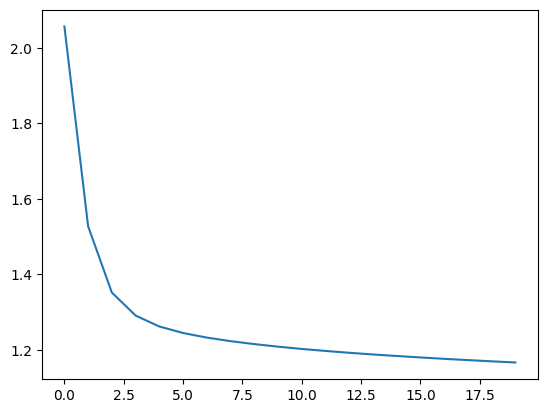

In [188]:
plt.plot(SimpleMLP_losses)
plt.show()